In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# Sigmoid function for binarization

def sigmoid(x):
    return 1 / (1 + np.exp(-10 * (x - 0.5)))

def binarize(x):
    return (sigmoid(x) >= np.random.rand(*x.shape)).astype(int)


# Fitness function: Eq. (8)

def fitness_function(solution, X_train, X_test, y_train, y_test, alpha=0.9):
    selected_features = np.where(solution == 1)[0]
    if len(selected_features) == 0:
        return 1.0  # Worst fitness if no features selected

    X_train_sel = X_train[:, selected_features]
    X_test_sel = X_test[:, selected_features]

    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_sel, y_train)
    error_rate = 1 - clf.score(X_test_sel, y_test)

    beta = 1 - alpha
    feature_ratio = len(selected_features) / X_train.shape[1]

    return alpha * error_rate + beta * feature_ratio


# BAOA main algorithm

def BAOA(X_train, X_test, y_train, y_test, n_solutions=10, T=50, alpha_param=2, MinMOA=0.2, MaxMOA=1.0, mu=0.5):
    n_features = X_train.shape[1]
    positions = np.random.randint(0, 2, size=(n_solutions, n_features)).astype(float)
    best_solution = None
    best_fitness = float('inf')
    convergence = []

    for t in range(T):
        fitness_vals = np.array([fitness_function(pos, X_train, X_test, y_train, y_test) for pos in positions])
        min_idx = np.argmin(fitness_vals)
        if fitness_vals[min_idx] < best_fitness:
            best_fitness = fitness_vals[min_idx]
            best_solution = positions[min_idx].copy()
        convergence.append(best_fitness)

        MOA = MinMOA + t * (MaxMOA - MinMOA) / T
        MOP = 1 - (t / T) ** (1 / alpha_param)

        for i in range(n_solutions):
            for j in range(n_features):
                r1, r2, r3 = np.random.rand(3)
                if r1 > MOA:
                    if r2 > 0.5:
                        positions[i, j] = best_solution[j] * MOP + mu
                        positions[i, j] = binarize(np.array([positions[i, j]]))[0]
                    else:
                        positions[i, j] = best_solution[j] * MOP * mu
                        positions[i, j] = binarize(np.array([positions[i, j]]))[0]
                else:
                    if r3 > 0.5:
                        positions[i, j] = best_solution[j] - MOP * mu
                        positions[i, j] = binarize(np.array([positions[i, j]]))[0]
                    else:
                        positions[i, j] = best_solution[j] + MOP * mu
                        positions[i, j] = binarize(np.array([positions[i, j]]))[0]

    return best_solution, best_fitness, convergence





The Sonar dataset has:

60 features

Each feature is a continuous numeric value

Meaning:

**Each feature represents the energy of a sonar signal reflected from a rock or a metal cylinder in a specific frequency band.**

What each feature physically represents?

The Sonar dataset is based on active sonar experiments where:

* A sonar transmitter emits an ultrasonic pulse toward a target.

* The pulse reflects off the object (either metal cylinder or rock).

* A sensor records the returned echo signal.

That raw echo signal is then captured.

The 60 features correspond to 60 frequency bands (0–59).

Feature names are usually labeled: F1, F2, F3, ..., F60

| Feature | Meaning                                                     |
| ------- | ----------------------------------------------------------- |
| **F1**  | Energy of the echo in window 1 (closest to the transmitter) |
| **F2**  | Energy in window 2                                          |
| ...     | ...                                                         |
| **F60** | Energy in the final time window (echo tail)                 |


In [2]:
# --- SonarEW Dataset ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Sonar dataset
url_sonar = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data_sonar = pd.read_csv(url_sonar, header=None)

# Features and labels
X_sonar = data_sonar.iloc[:, :-1].values
y_sonar = data_sonar.iloc[:, -1].values

# Encode labels: M -> 1, R -> 0
le_sonar = LabelEncoder()
y_sonar = le_sonar.fit_transform(y_sonar)

# Train/test split
X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar = train_test_split(
    X_sonar, y_sonar, test_size=0.3, random_state=42
)

print("SonarEW - X_train:", X_train_sonar.shape, "X_test:", X_test_sonar.shape)


SonarEW - X_train: (145, 60) X_test: (63, 60)


BreastEW Dataset

This dataset contains 30 features describing the cell nuclei from digitized breast mass images.
All features are computed from fine needle aspirates (FNA) of breast tissue.

Each of the 10 base features is measured in three forms:

1.   Mean value
2.   Standard Error (SE)
3.   Worst value (max over the largest three nuclei)

30 features = 10 base features × 3 (mean, SE, worst)

1. Radius

Average distance from the center to points on the perimeter.

Large radius → larger nuclei → potential malignancy.

2. Texture

Variation in gray-scale values in the nucleus.

Reflects coarseness or smoothness of chromatin.

Cancer cells often exhibit irregular texture patterns.

3. Perimeter

Length around the nucleus.

Correlated with radius but sensitive to boundary irregularities.

4. Area

Total number of pixels within the nucleus.

Larger area is often associated with tumor cells expanding in size.

5. Smoothness

Measures local variation in radius length.

Higher smoothness = smoother boundary

Lower smoothness = jagged, irregular edges → more likely malignant.

6. Compactness

High values indicate irregular or non-circular shapes typical of cancer cells.

7. Concavity

Severity of concave portions of the contour.

High concavity is strongly correlated with malignancy.

8. Concave Points

Number of concave sections in the boundary.

Higher = more irregular shape → malignant indicator.

9. Symmetry

Measures how symmetric the nucleus is.

Cancer cells tend to be less symmetric.

10. Fractal Dimension

Approximation of coastline-like irregularity of the boundary.
Higher values represent complex, irregular edges.



In [3]:
# --- BreastEW Dataset ---
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load dataset
data_breast = load_breast_cancer()
X_breast = data_breast.data      # 569 samples, 30 features
y_breast = data_breast.target    # 0 = malignant, 1 = benign

# Train/test split
X_train_breast, X_test_breast, y_train_breast, y_test_breast = train_test_split(
    X_breast, y_breast, test_size=0.3, random_state=42
)

# Feature scaling
scaler_breast = StandardScaler()
X_train_breast = scaler_breast.fit_transform(X_train_breast)
X_test_breast = scaler_breast.transform(X_test_breast)

print("BreastEW - X_train:", X_train_breast.shape, "X_test:", X_test_breast.shape)


BreastEW - X_train: (398, 30) X_test: (171, 30)


Why were these features selected for the SonarEW?

✔ High correlation with label (using the correlation list)

✔ High variance (features that provide more information)

✔ Low redundancy (using correlation between features)

✔ Improved classification accuracy (KNN measures this in the fitness function)

In [4]:
# Run BAOA for SonarEW
best_solution_sonar, best_fitness_sonar, convergence_sonar = BAOA(
    X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar,
    n_solutions=20,  # number of candidate solutions
    T=50             # number of iterations
)

# Get selected features
selected_features_sonar = np.where(best_solution_sonar == 1)[0]

print("SonarEW - Selected features indices:", selected_features_sonar)
print("SonarEW - Best fitness value:", best_fitness_sonar)


SonarEW - Selected features indices: [ 0  7  9 14 21 25 26 28 30 31 35 41 43 44 45 46]
SonarEW - Best fitness value: 0.05523809523809523


Why were these features selected for the BreastEW?

✔ Larger nuclei (↑ radius, ↑ area, ↑ perimeter)

✔ More irregular shape (↑ concavity, ↑ compactness, ↑ fractal dimension)

✔ Less symmetry

✔ More extreme "worst" cases among nuclei

✔ More variability in chromatin (↑ texture)

In [5]:
# Run BAOA for BreastEW
best_solution_breast, best_fitness_breast, convergence_breast = BAOA(
    X_train_breast, X_test_breast, y_train_breast, y_test_breast,
    n_solutions=20,
    T=50
)

# Get selected features
selected_features_breast = np.where(best_solution_breast == 1)[0]

print("BreastEW - Selected features indices:", selected_features_breast)
print("BreastEW - Best fitness value:", best_fitness_breast)


BreastEW - Selected features indices: [ 0  1  8  9 20 24]
BreastEW - Best fitness value: 0.03052631578947368


In [6]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Example for SonarEW
knn_sonar = KNeighborsClassifier(n_neighbors=3)
knn_sonar.fit(X_train_sonar[:, selected_features_sonar], y_train_sonar)
y_pred_sonar = knn_sonar.predict(X_test_sonar[:, selected_features_sonar])
print("SonarEW - Accuracy with selected features:", accuracy_score(y_test_sonar, y_pred_sonar))

# Example for BreastEW
knn_breast = KNeighborsClassifier(n_neighbors=3)
knn_breast.fit(X_train_breast[:, selected_features_breast], y_train_breast)
y_pred_breast = knn_breast.predict(X_test_breast[:, selected_features_breast])
print("BreastEW - Accuracy with selected features:", accuracy_score(y_test_breast, y_pred_breast))

SonarEW - Accuracy with selected features: 0.9682539682539683
BreastEW - Accuracy with selected features: 0.9883040935672515


In [7]:
# Binary Particle Swarm Optimization (BPSO) with Convergence Tracking
def BPSO(X_train, X_test, y_train, y_test,
                     n_particles=20, T=50, w=0.7, c1=1.5, c2=1.5):

    n_features = X_train.shape[1]

    # Initialize positions and velocities
    positions = np.random.randint(0, 2, size=(n_particles, n_features)).astype(float)
    velocities = np.random.rand(n_particles, n_features)

    # Personal best
    pbest = positions.copy()
    pbest_fitness = np.array([fitness_function(p, X_train, X_test, y_train, y_test)
                              for p in positions])

    # Global best
    gbest_idx = np.argmin(pbest_fitness)
    gbest = pbest[gbest_idx].copy()
    gbest_fitness = pbest_fitness[gbest_idx]

    # Convergence list
    convergence = []

    for t in range(T):

        for i in range(n_particles):

            r1, r2 = np.random.rand(n_features), np.random.rand(n_features)

            # Velocity update
            velocities[i] = (
                w * velocities[i] +
                c1 * r1 * (pbest[i] - positions[i]) +
                c2 * r2 * (gbest - positions[i])
            )

            # Position update (binary)
            positions[i] = binarize(velocities[i])

            # Evaluate fitness
            fit = fitness_function(positions[i], X_train, X_test, y_train, y_test)

            # Update personal best
            if fit < pbest_fitness[i]:
                pbest[i] = positions[i].copy()
                pbest_fitness[i] = fit

        # Update global best
        gbest_idx = np.argmin(pbest_fitness)
        gbest = pbest[gbest_idx].copy()
        gbest_fitness = pbest_fitness[gbest_idx]

        # Store convergence
        convergence.append(gbest_fitness)

    return gbest, gbest_fitness, convergence


In [8]:
# BDF
def BDF(X_train, X_test, y_train, y_test, n_agents=20, T=50):

    n_features = X_train.shape[1]
    positions = np.random.randint(0, 2, size=(n_agents, n_features)).astype(float)

    best_solution = None
    best_fitness = float('inf')

    convergence = []  # track best fitness

    for t in range(T):

        # Evaluate fitness
        fitness_vals = np.array([
            fitness_function(pos, X_train, X_test, y_train, y_test)
            for pos in positions
        ])

        min_idx = np.argmin(fitness_vals)
        if fitness_vals[min_idx] < best_fitness:
            best_fitness = fitness_vals[min_idx]
            best_solution = positions[min_idx].copy()

        # Store convergence
        convergence.append(best_fitness)

        # Update positions (binary, simplified)
        for i in range(n_agents):
            for j in range(n_features):
                r = np.random.rand()
                if r < 0.5:
                    positions[i, j] = best_solution[j]   # move toward best
                else:
                    positions[i, j] = 1 - positions[i, j]  # flip bit

    return best_solution, best_fitness, convergence


In [9]:
# BGA
def BGA(X_train, X_test, y_train, y_test,
                    n_pop=20, T=50, crossover_prob=0.8, mutation_prob=0.1):

    n_features = X_train.shape[1]
    pop = np.random.randint(0, 2, size=(n_pop, n_features))

    best_solution = None
    best_fitness = float('inf')

    convergence = []  # store best fitness

    for t in range(T):

        fitness_vals = np.array([
            fitness_function(ind, X_train, X_test, y_train, y_test)
            for ind in pop
        ])

        min_idx = np.argmin(fitness_vals)
        if fitness_vals[min_idx] < best_fitness:
            best_fitness = fitness_vals[min_idx]
            best_solution = pop[min_idx].copy()

        # Store convergence
        convergence.append(best_fitness)

        # --- Tournament Selection ---
        selected = []
        for _ in range(n_pop):
            i1, i2 = np.random.randint(0, n_pop, 2)
            winner = i1 if fitness_vals[i1] < fitness_vals[i2] else i2
            selected.append(pop[winner])
        selected = np.array(selected)

        # --- Crossover ---
        for i in range(0, n_pop, 2):
            if np.random.rand() < crossover_prob:
                point = np.random.randint(1, n_features-1)
                selected[i, point:], selected[i+1, point:] = (
                    selected[i+1, point:].copy(),
                    selected[i, point:].copy()
                )

        # --- Mutation ---
        mutation_mask = np.random.rand(n_pop, n_features) < mutation_prob
        selected = np.where(mutation_mask, 1 - selected, selected)

        pop = selected.copy()

    return best_solution, best_fitness, convergence


In [10]:
def BCAT(X_train, X_test, y_train, y_test,
                     n_cats=20, T=50, seeking_prob=0.5):

    n_features = X_train.shape[1]
    positions = np.random.randint(0, 2, size=(n_cats, n_features)).astype(float)

    best_solution = None
    best_fitness = float('inf')
    convergence = []

    for t in range(T):

        # Evaluate fitness
        fitness_vals = np.array([
            fitness_function(pos, X_train, X_test, y_train, y_test)
            for pos in positions
        ])

        min_idx = np.argmin(fitness_vals)
        if fitness_vals[min_idx] < best_fitness:
            best_fitness = fitness_vals[min_idx]
            best_solution = positions[min_idx].copy()

        # Store convergence
        convergence.append(best_fitness)

        # Update positions
        for i in range(n_cats):
            r = np.random.rand()
            if r < seeking_prob:  # Seeking mode
                bit_to_flip = np.random.randint(0, n_features)
                positions[i, bit_to_flip] = 1 - positions[i, bit_to_flip]
            else:  # Tracing mode
                j = np.random.randint(0, n_features)
                positions[i, j] = best_solution[j]

    return best_solution, best_fitness, convergence


In [11]:
def run_comparison(X_train, X_test, y_train, y_test):
    results = {}
    convergence_curves = {}

    # Use convergence-enabled versions
    optimizers = {
        'BAOA': BAOA,
        'BPSO': BPSO,
        'BDF': BDF,
        'BGA': BGA,
        'BCAT': BCAT
    }

    for name, opt in optimizers.items():
        best_sol, best_fit, conv = opt(X_train, X_test, y_train, y_test)
        selected_features = np.where(best_sol == 1)[0]

        # Evaluate KNN accuracy
        clf = KNeighborsClassifier(n_neighbors=3)
        if len(selected_features) == 0:
            acc = 0.0
        else:
            clf.fit(X_train[:, selected_features], y_train)
            acc = clf.score(X_test[:, selected_features], y_test)

        results[name] = {
            'Fitness': best_fit,
            'Num_Features': len(selected_features),
            'Accuracy': acc
        }

        # Store convergence curve
        convergence_curves[name] = conv

    df_results = pd.DataFrame(results).T
    return df_results, convergence_curves

# --- Run for SonarEW ---
print("===== SonarEW Comparison =====")
df_sonar, curves_sonar = run_comparison(X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar)
print(df_sonar)

# --- Run for BreastEW ---
print("\n===== BreastEW Comparison =====")
df_breast, curves_breast = run_comparison(X_train_breast, X_test_breast, y_train_breast, y_test_breast)
print(df_breast)


===== SonarEW Comparison =====
       Fitness  Num_Features  Accuracy
BAOA  0.058571          18.0  0.968254
BPSO  0.045238          10.0  0.968254
BDF   0.067619          32.0  0.984127
BGA   0.071905          26.0  0.968254
BCAT  0.088810          19.0  0.936508

===== BreastEW Comparison =====
       Fitness  Num_Features  Accuracy
BAOA  0.037193           8.0  0.988304
BPSO  0.020526           3.0  0.988304
BDF   0.047193          11.0  0.988304
BGA   0.037719           5.0  0.976608
BCAT  0.045789           9.0  0.982456


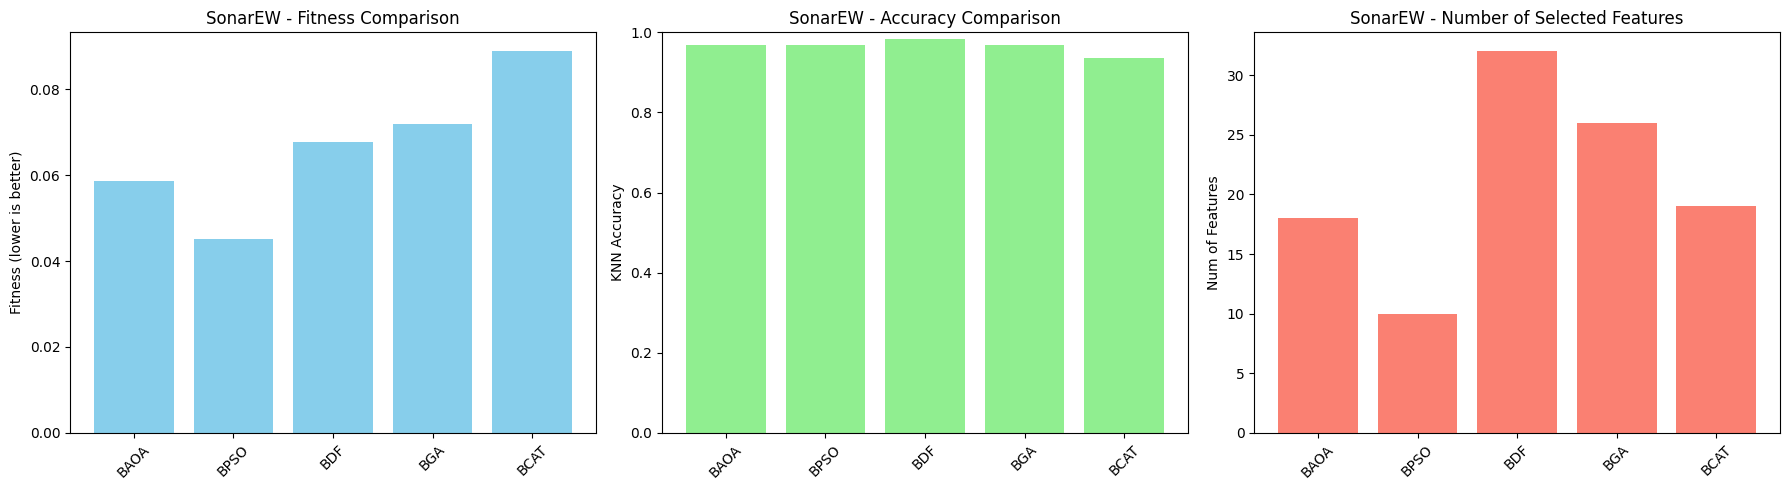

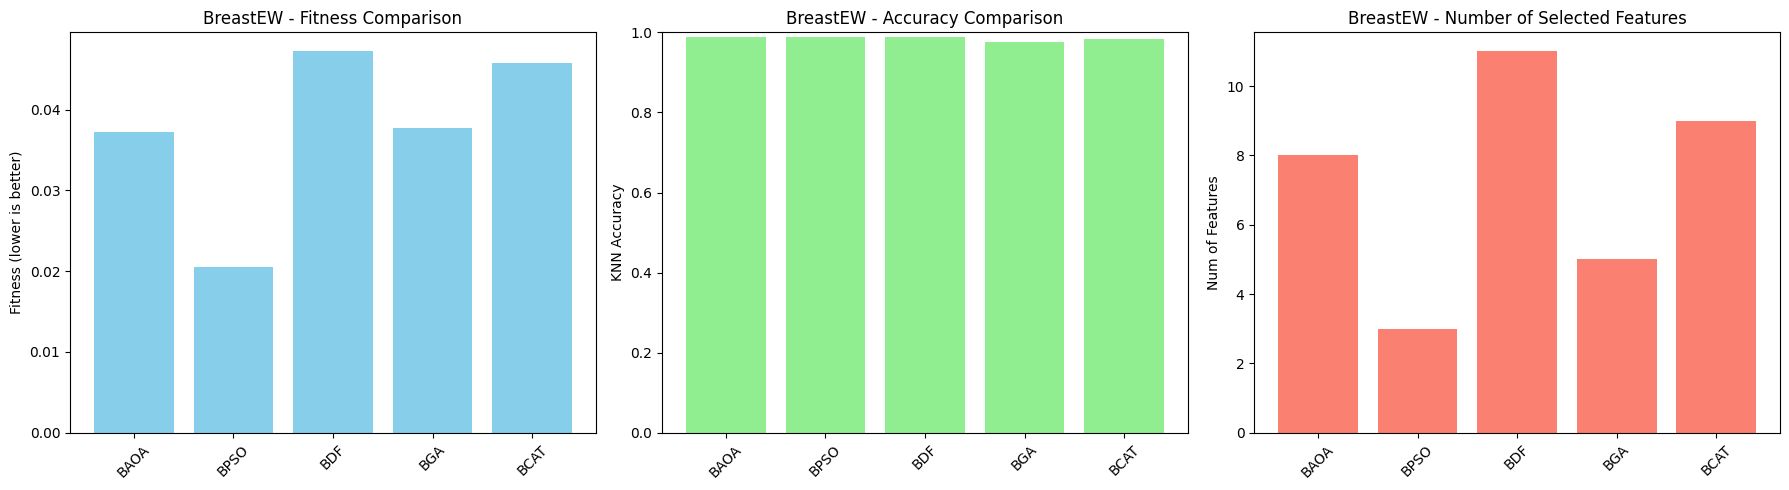

In [12]:
import matplotlib.pyplot as plt

def plot_comparison(df_results, dataset_name):
    optimizers = df_results.index
    fitness = df_results['Fitness']
    accuracy = df_results['Accuracy']
    num_features = df_results['Num_Features']

    plt.figure(figsize=(18,5))

    # --- Fitness ---
    plt.subplot(1,3,1)
    plt.bar(optimizers, fitness, color='skyblue')
    plt.title(f'{dataset_name} - Fitness Comparison')
    plt.ylabel('Fitness (lower is better)')
    plt.xticks(rotation=45)

    # --- Accuracy ---
    plt.subplot(1,3,2)
    plt.bar(optimizers, accuracy, color='lightgreen')
    plt.title(f'{dataset_name} - Accuracy Comparison')
    plt.ylabel('KNN Accuracy')
    plt.ylim(0,1)
    plt.xticks(rotation=45)

    # --- Number of Features ---
    plt.subplot(1,3,3)
    plt.bar(optimizers, num_features, color='salmon')
    plt.title(f'{dataset_name} - Number of Selected Features')
    plt.ylabel('Num of Features')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# --- Plot for SonarEW ---
plot_comparison(df_sonar, 'SonarEW')

# --- Plot for BreastEW ---
plot_comparison(df_breast, 'BreastEW')


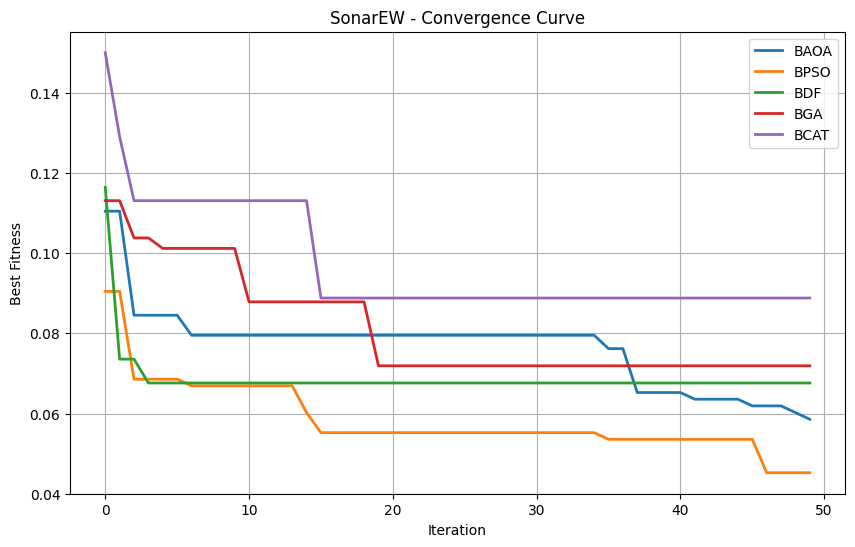

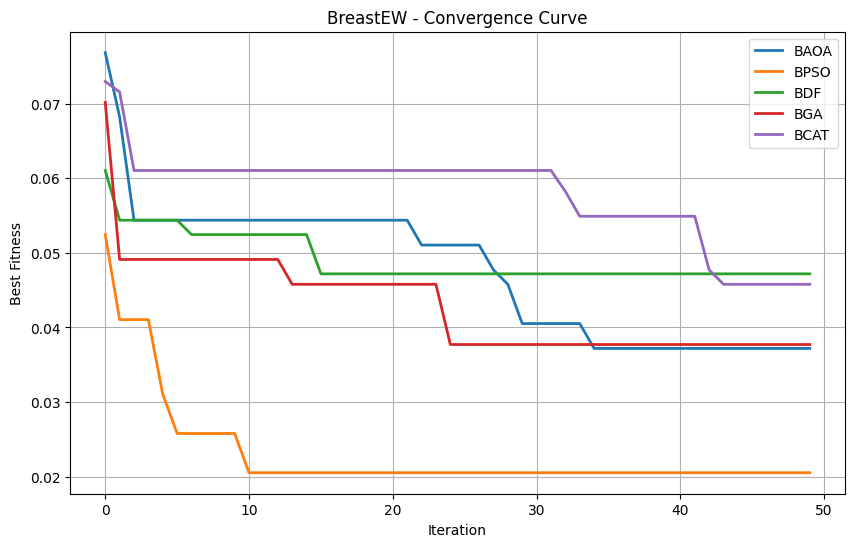

In [13]:
import matplotlib.pyplot as plt

def plot_convergence(curves, dataset_name):
    plt.figure(figsize=(10,6))
    for name, conv in curves.items():
        plt.plot(conv, label=name, linewidth=2)
    plt.title(f'{dataset_name} - Convergence Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for SonarEW
plot_convergence(curves_sonar, 'SonarEW')

# Plot for BreastEW
plot_convergence(curves_breast, 'BreastEW')


In [17]:
import numpy as np
import pandas as pd
from scipy.stats import sem, t
from sklearn.neighbors import KNeighborsClassifier


# 1) Statistical analysis function

def statistical_analysis(acc_list):
    acc_array = np.array(acc_list)

    minimum = np.min(acc_array)
    median = np.median(acc_array)
    maximum = np.max(acc_array)
    value_range = maximum - minimum
    mean_val = np.mean(acc_array)
    std_val = np.std(acc_array, ddof=1)  # unbiased std
    sem_val = sem(acc_array)

    # Quartiles
    q1 = np.percentile(acc_array, 25)
    q3 = np.percentile(acc_array, 75)

    # 95% confidence interval
    confidence = 0.95
    df = len(acc_array) - 1
    t_crit = t.ppf((1 + confidence) / 2, df)
    margin = t_crit * sem_val
    lower = mean_val - margin
    upper = mean_val + margin

    return {
        "Min": minimum,
        "Median": median,
        "Max": maximum,
        "Range": value_range,
        "Mean": mean_val,
        "Std": std_val,
        "SEM (Error of Mean)": sem_val,
        "25% Percentile": q1,
        "75% Percentile": q3,
        "Actual Confidence Level": confidence,
        "Lower CL": lower,
        "Upper CL": upper
    }



# 2) Full statistical evaluation loop

def evaluate_statistics(X_train, X_test, y_train, y_test, runs=30):
    optimizers = {
        'BAOA': BAOA,
        'BPSO': BPSO,
        'BDF': BDF,
        'BGA': BGA,
        'BCAT': BCAT
    }

    stats_result = {}

    for name, opt in optimizers.items():
        acc_list = []

        for _ in range(runs):
            best_sol, best_fit, _ = opt(X_train, X_test, y_train, y_test)
            selected = np.where(best_sol == 1)[0]

            if len(selected) == 0:
                acc = 0.0
            else:
                clf = KNeighborsClassifier(n_neighbors=3)
                clf.fit(X_train[:, selected], y_train)
                acc = clf.score(X_test[:, selected], y_test)

            acc_list.append(acc)

        stats_result[name] = statistical_analysis(acc_list)

    return pd.DataFrame(stats_result).T


In [19]:
print("\n===== Statistical Analysis: SonarEW =====")
stats_sonar = evaluate_statistics(X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar, runs=30)
print(stats_sonar)

print("\n===== Statistical Analysis: BreastEW =====")
stats_breast = evaluate_statistics(X_train_breast, X_test_breast, y_train_breast, y_test_breast, runs=30)
print(stats_breast)



===== Statistical Analysis: SonarEW =====
           Min    Median       Max     Range      Mean       Std  \
BAOA  0.936508  0.968254  0.984127  0.047619  0.970899  0.013237   
BPSO  0.936508  0.968254  0.984127  0.047619  0.967725  0.012141   
BDF   0.936508  0.968254  0.984127  0.047619  0.962963  0.011288   
BGA   0.952381  0.968254  0.984127  0.031746  0.969841  0.007630   
BCAT  0.936508  0.952381  0.968254  0.031746  0.952910  0.011403   

      SEM (Error of Mean)  25% Percentile  75% Percentile  \
BAOA             0.002417        0.968254        0.984127   
BPSO             0.002217        0.968254        0.968254   
BDF              0.002061        0.952381        0.968254   
BGA              0.001393        0.968254        0.968254   
BCAT             0.002082        0.952381        0.964286   

      Actual Confidence Level  Lower CL  Upper CL  
BAOA                     0.95  0.965957  0.975842  
BPSO                     0.95  0.963191  0.972258  
BDF                      